In [1]:
from IPython.display import HTML, display
display(HTML('<style>.container{ width:100% !important; }</style>'))

# Packages import

In [3]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from k_means_constrained import KMeansConstrained
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from functools import reduce
from scipy.stats.mstats import gmean

In [4]:
df = pd.read_csv('cluster_data_CE_june_trial.csv', encoding='utf-8')
bootstrap_df = pd.DataFrame(columns=['int_cntr_code', 'RMS_ID', 'store', 'bootstrap_uplift_mean'])
bootstrap_df_list = []

In [5]:
import time
start_time = time.time()

grouped_data = df.groupby(['int_cntr_code', 'RMS_ID', 'store'])
for group, data in grouped_data:
    uplifts = data['weekend_uplift']
    meanlist = []
    
    for i in range(500):
        sampled_uplifts = uplifts.sample(frac=1, replace=True)
        geo_mean = np.exp(np.mean(np.log(sampled_uplifts)))
        meanlist.append(geo_mean)
    bootstrap_mean = np.mean(meanlist)

    # Append the results to list
    bootstrap_df_list.append({'int_cntr_code': group[0], 'RMS_ID': group[1], 'store': group[2],
                              'bootstrap_uplift_mean': bootstrap_mean})
  
bootstrap_df = pd.DataFrame(bootstrap_df_list)
df = pd.merge(df[['int_cntr_code', 'RMS_ID', 'store', 'dmat_dep_code', 'dmat_dep_des_en', 'store_name', 'store_size_cluster']],
              bootstrap_df, how='inner', on=['int_cntr_code', 'RMS_ID', 'store'])

df.drop_duplicates(inplace=True)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

Elapsed time: 315.2575557231903 seconds


# KMEANS clustering

In [6]:
df_clus = df[[col for col in df.columns if col not in ['dmat_dep_code','dmat_dep_des_en']]]
df_clus.set_index('store',inplace=True)
features = [str(col) for col in df_clus.columns if col not in ['int_cntr_code','RMS_ID','dmat_dep_code','dmat_dep_des_en','store_size_cluster','store_name']]
features

['bootstrap_uplift_mean']

In [13]:
df_all = pd.DataFrame()
for country in df_clus['int_cntr_code'].unique():
    for dep in df_clus['RMS_ID'].unique():
        for cluster in df_clus['store_size_cluster'].unique():
            df2 = df_clus[(df_clus['RMS_ID']==dep)&(df_clus['store_size_cluster']==cluster)&(df_clus['int_cntr_code']==country)].copy()
            print(df2.shape,country,dep,cluster)
            input_data = df2[features]
            if cluster == 'Small':
                kmeans = KMeansConstrained(n_clusters = 4,size_min=10,tol=0.01, max_iter = 10000)
            else:
                kmeans = KMeansConstrained(n_clusters = 4,size_min=10,tol=0.01, max_iter = 10000)
            kmeans.fit(input_data)
            df2['cluster'] = kmeans.labels_
            df_all = pd.concat([df_all,df2])

(89, 5) HU 114 Large
(108, 5) HU 114 Small
(96, 5) HU 112 Large
(101, 5) HU 112 Small
(94, 5) HU 113 Large
(103, 5) HU 113 Small
(78, 5) SK 114 Large
(79, 5) SK 114 Small
(77, 5) SK 112 Large
(92, 5) SK 112 Small
(74, 5) SK 113 Large
(95, 5) SK 113 Small
(90, 5) CZ 114 Large
(90, 5) CZ 114 Small
(91, 5) CZ 112 Large
(91, 5) CZ 112 Small
(90, 5) CZ 113 Large
(92, 5) CZ 113 Small


In [14]:
check_df = df_all.groupby(['int_cntr_code','cluster','RMS_ID','store_size_cluster'],as_index=False).agg({'bootstrap_uplift_mean': ['count','mean']})
columns = []
for c in check_df.columns:
    if c[1]=='':
        columns.append(c[0])
    else:
        columns.append(c[1])
check_df.columns = columns
check_df = check_df.sort_values(by=['int_cntr_code','RMS_ID','store_size_cluster','mean'])
check_df['id'] = check_df.groupby(['RMS_ID', 'int_cntr_code', 'store_size_cluster']).cumcount() + 1
check_df['new_name_cluster'] = np.where(check_df['id']==1,'Weak',
                                        np.where(check_df['id']==2,'Moderate',
                                                 np.where(check_df['id']==3,'Intense','Heavy')))
                                                          #np.where(check_df['id']==4,'Important','Heavy'))))
check_df.drop(columns=['id'],inplace=True)
check_df['store_cluster'] = check_df['store_size_cluster'] + '-' + check_df['new_name_cluster']
df_all2 = df_all.reset_index()
df_all2 = df_all2.merge(check_df[['int_cntr_code','RMS_ID','cluster','store_size_cluster','store_cluster']],how='inner',on=['cluster','RMS_ID','store_size_cluster','int_cntr_code'])
df_all2

,store,int_cntr_code,RMS_ID,store_name,store_size_cluster,bootstrap_uplift_mean,cluster,store_cluster
0,1029,HU,114,Szeged Szabadkai Extra,Large,1.031121,1,Large-Moderate
1,1850,HU,114,Komlo,Large,1.053480,1,Large-Moderate
2,1006,HU,114,Kazincbarcika,Large,1.050679,1,Large-Moderate
3,1420,HU,114,Szeged Extra,Large,1.042118,1,Large-Moderate
4,1840,HU,114,Szazhalombatta,Large,1.000041,1,Large-Moderate
...,...,...,...,...,...,...,...,...
1625,4045,CZ,113,Ceske Budejovice Krajinska,Small,0.970931,1,Small-Moderate
1626,4047,CZ,113,Osek,Small,0.965730,1,Small-Moderate
1627,4028,CZ,113,Plzen Doubravka,Small,0.968349,1,Small-Moderate
1628,4146,CZ,113,Praha Kodanska,Small,0.954571,1,Small-Moderate


In [15]:
melted_df = pd.melt(df_all2,id_vars=['int_cntr_code','store','store_name','RMS_ID','store_size_cluster','store_cluster'],value_vars=features)
melted_df = melted_df.rename(columns={'value':'uplift'})
melted_df[(melted_df['store']==1001)&(melted_df['int_cntr_code']=='SK')&(melted_df['RMS_ID']==112)]

,int_cntr_code,store,store_name,RMS_ID,store_size_cluster,store_cluster,variable,uplift
807,SK,1001,Nitra,112,Large,Large-Intense,bootstrap_uplift_mean,1.064562


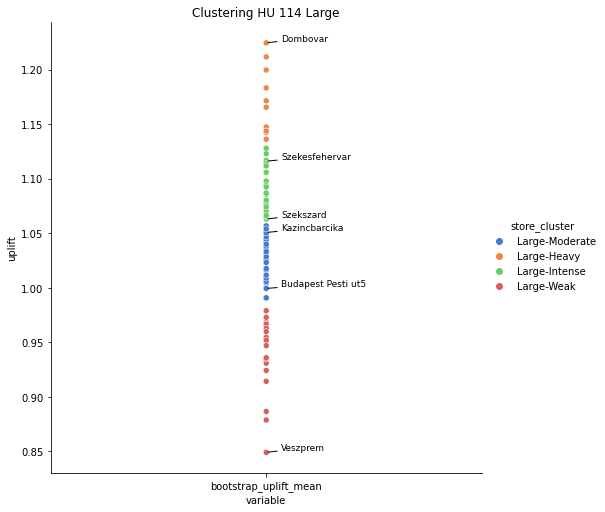

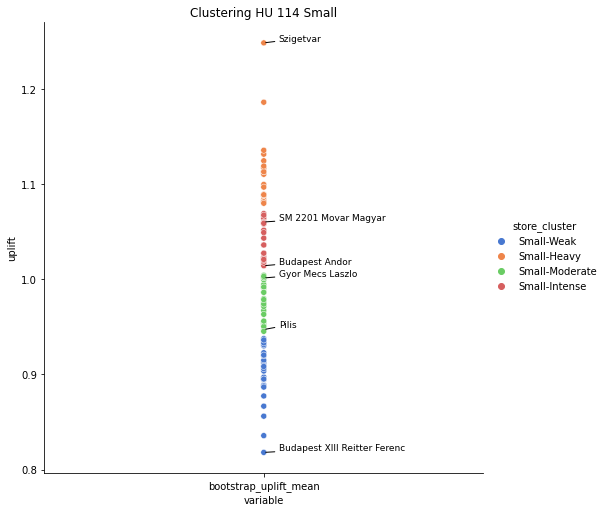

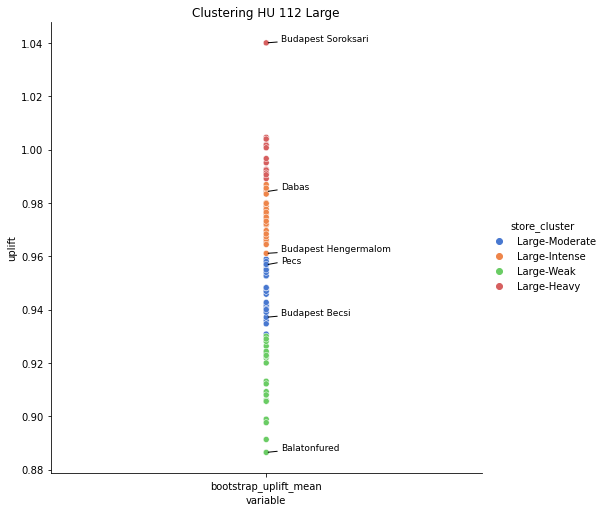

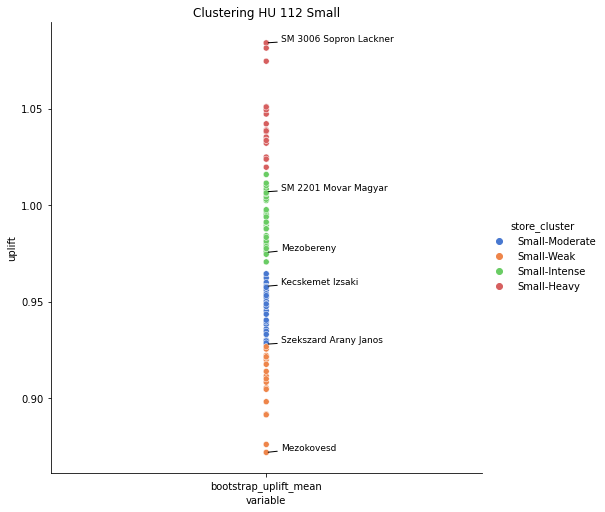

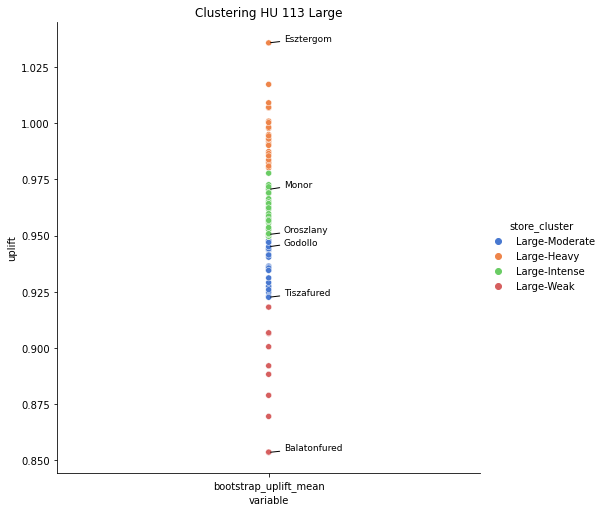

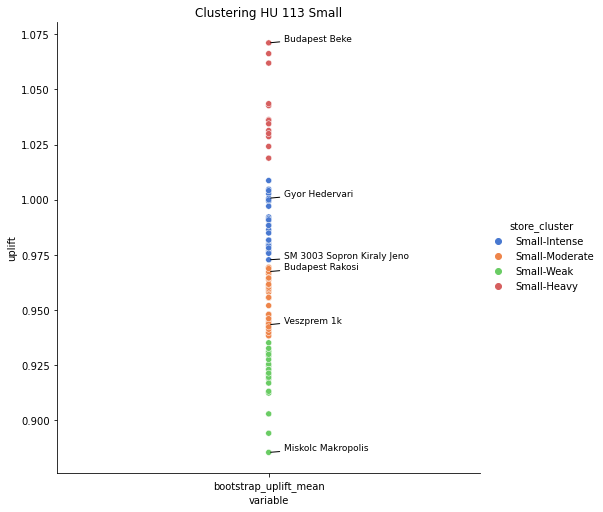

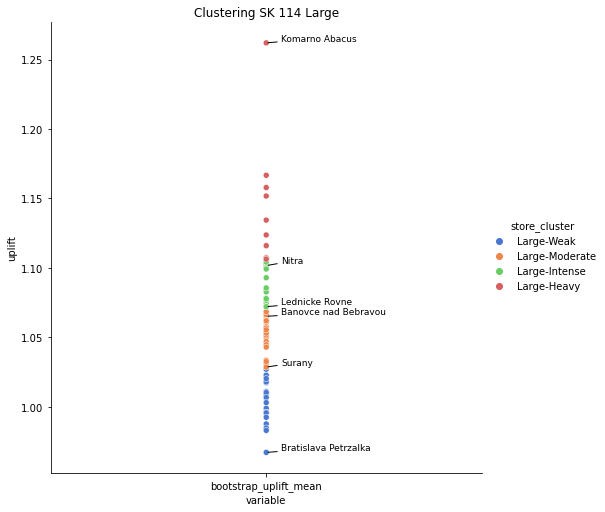

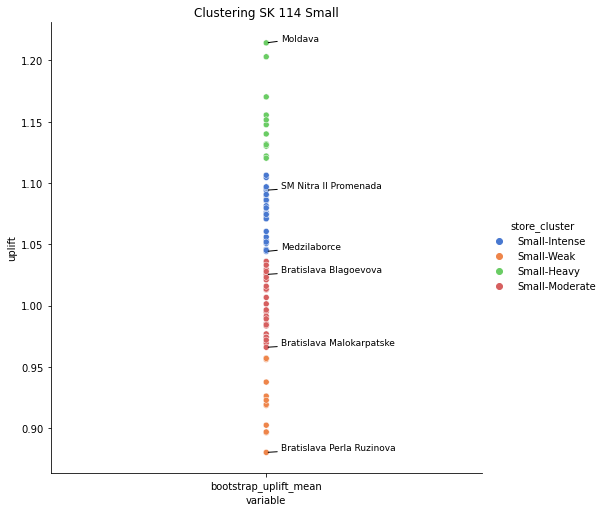

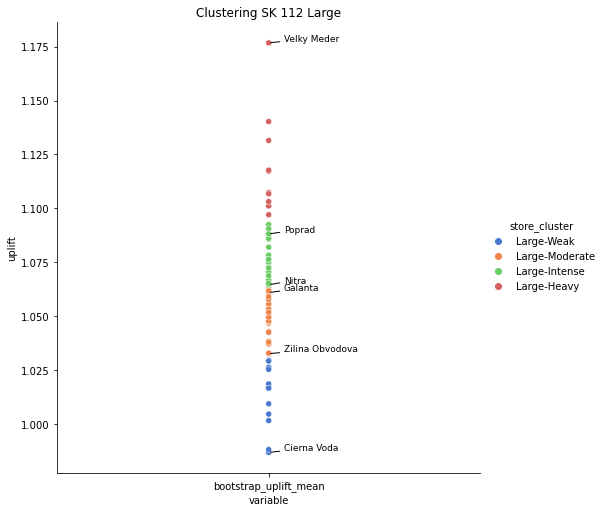

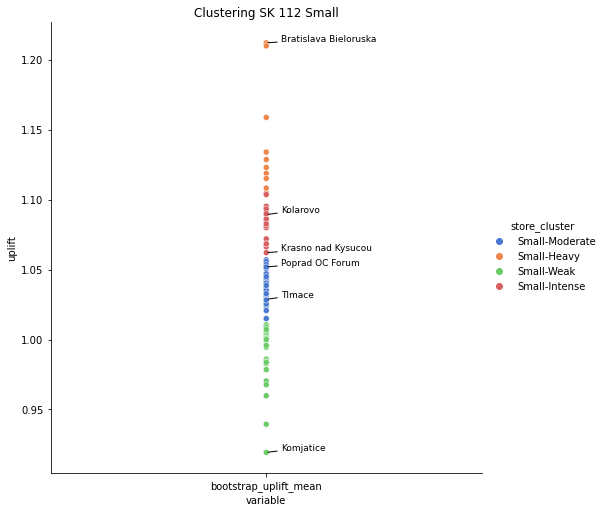

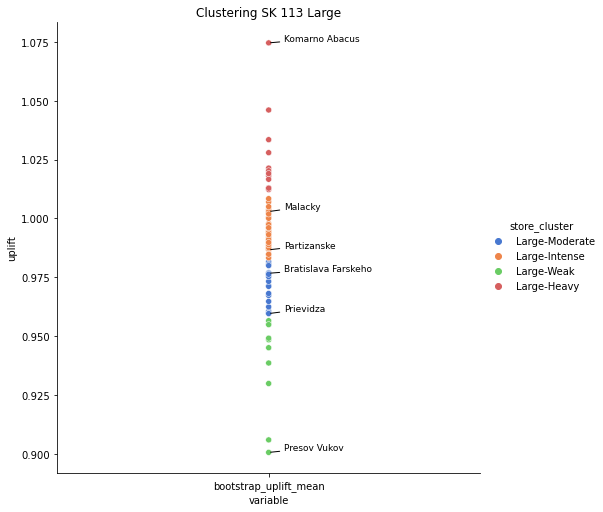

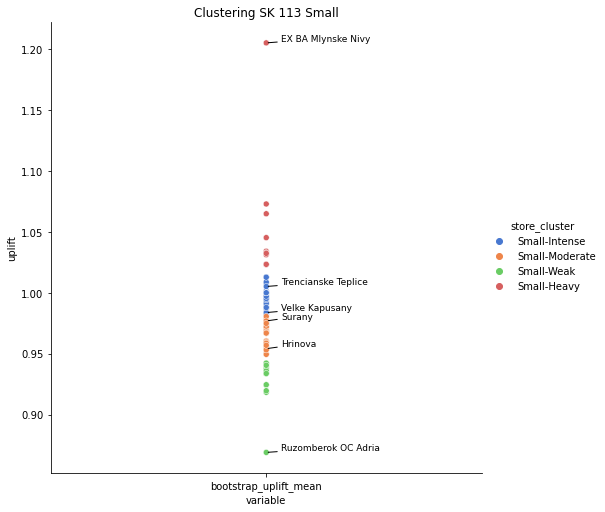

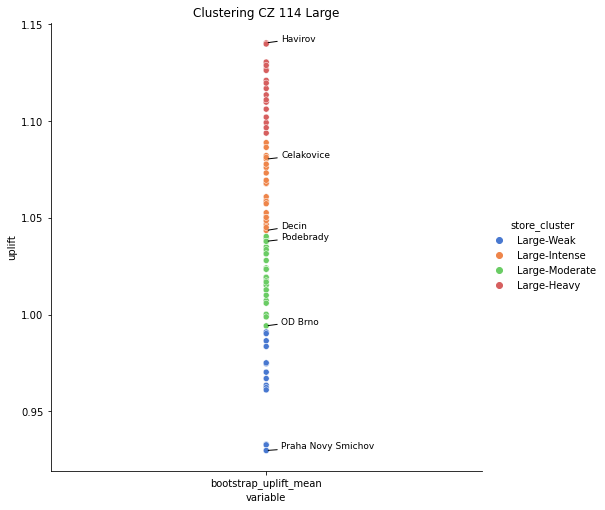

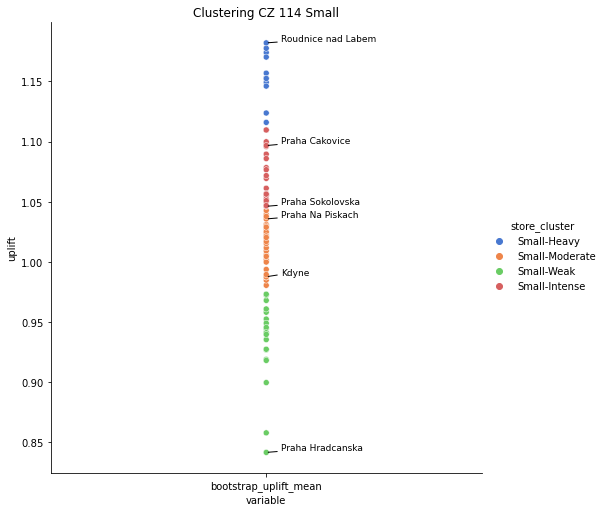

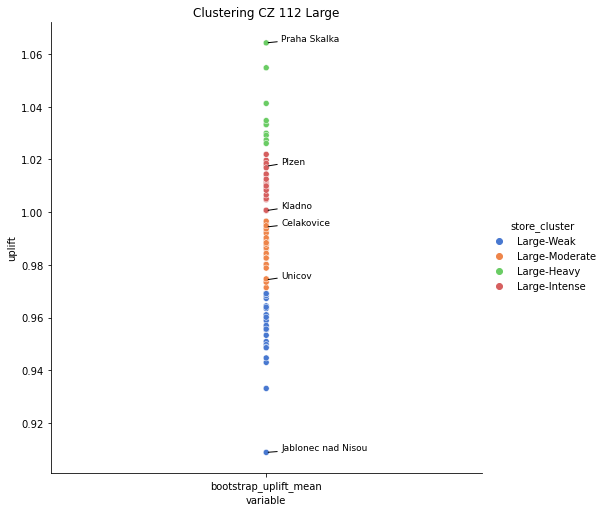

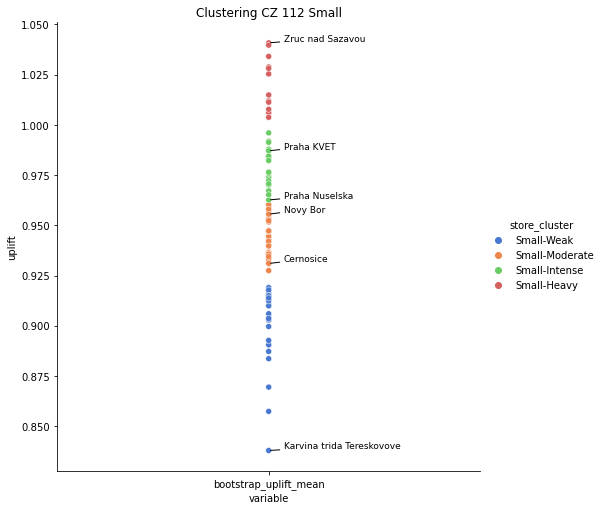

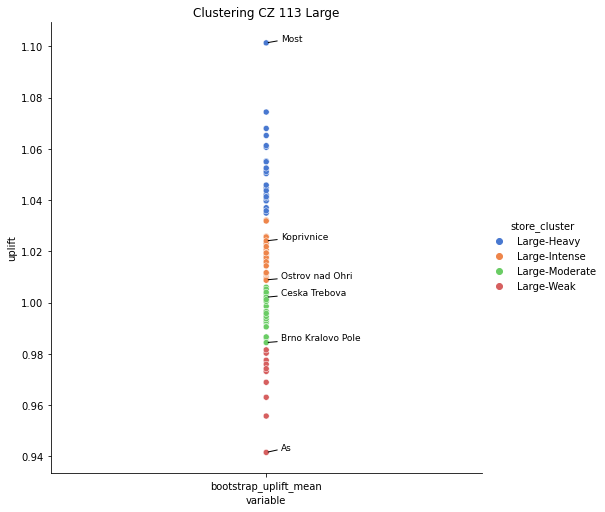

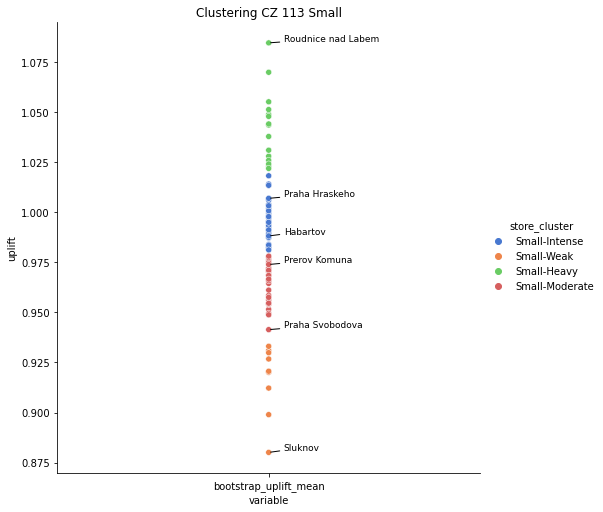

In [16]:
def annotate_low_outliers(df_group,ax,num_outliers=1):
    outliers = df_group.loc[df_group['uplift'].nsmallest(num_outliers).index]
    for idx, row in outliers.iterrows():
        ax.annotate(text=row['store_name'],
                xy=(row['variable'], row['uplift']),
                xytext=(15,0), # 5 points vertical offset
                textcoords="offset points",
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0"),
                fontsize=9,
                ha='left',
                va='bottom')

def annotate_high_outliers(df_group,ax,num_outliers=1):
    outliers = df_group.loc[df_group['uplift'].nlargest(num_outliers).index]
    for idx, row in outliers.iterrows():
        ax.annotate(text=row['store_name'],
                xy=(row['variable'], row['uplift']),
                xytext=(15,0), # 5 points vertical offset
                textcoords="offset points",
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0"),
                fontsize=9,
                ha='left',
                va='bottom')
        
def annotate_middle(df_group,ax):
    first = df_group['uplift'].nlargest(5).iloc[-1]
    second = df_group['uplift'].nlargest(30).iloc[-1]
    outliers = df_group[df_group['uplift'].isin([first,second])]
    for idx, row in outliers.iterrows():
        ax.annotate(text=row['store_name'],
                xy=(row['variable'], row['uplift']),
                xytext=(15,0), # 5 points vertical offset
                textcoords="offset points",
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0"),
                fontsize=9,
                ha='left',
                va='bottom')
    
for country in melted_df['int_cntr_code'].unique():
    for rms in melted_df['RMS_ID'].unique():
        for cluster in melted_df['store_size_cluster'].unique():
            df_loop = melted_df[(melted_df['RMS_ID']==rms)&(melted_df['store_size_cluster']==cluster)&(melted_df['int_cntr_code']==country)]
            plot = sns.relplot(x='variable',y='uplift',data=df_loop,kind='scatter',hue='store_cluster',palette='muted',height=7,ci=None,legend='full').set(title='Clustering '+country + ' '+str(rms)+' '+str(cluster))
            for final_cluster in df_loop['store_cluster'].unique():
                df_loop_i = df_loop[df_loop['store_cluster']==final_cluster]
                if final_cluster in ['Small-Heavy','Large-Heavy']:
                    annotate_high_outliers(df_loop_i, plot.ax)
                elif final_cluster in ['Small-Weak','Large-Weak']:
                    annotate_low_outliers(df_loop_i, plot.ax)
                else:
                    annotate_middle(df_loop_i, plot.ax)
            plt.show()

In [17]:
df_all3 = df_all2[['int_cntr_code','store','store_name','RMS_ID','store_cluster','bootstrap_uplift_mean']].sort_values(by='store_cluster',ascending=True)
df_all3[(df_all3['store_cluster']=='Small-Heavy')&(df_all3['RMS_ID']==114)&(df_all3['int_cntr_code']=='SK')].sort_values(by='store',ascending=True)

,int_cntr_code,store,store_name,RMS_ID,store_cluster,bootstrap_uplift_mean
721,SK,4002,Krupina,114,Small-Heavy,1.140065
717,SK,4004,Tvrdosin,114,Small-Heavy,1.131213
715,SK,4035,Turcianske Teplice,114,Small-Heavy,1.155490
714,SK,4040,Secovce,114,Small-Heavy,1.203051
719,SK,4046,Spisska Bela,114,Small-Heavy,1.170313
710,SK,4067,Sladkovicovo,114,Small-Heavy,1.130125
716,SK,4072,Michalovce Spitalska,114,Small-Heavy,1.147640
711,SK,4101,Moldava,114,Small-Heavy,1.214371
713,SK,4102,Krompachy,114,Small-Heavy,1.122060
720,SK,4144,Poltar,114,Small-Heavy,1.120328


In [18]:
df_all3 = df_all3[['int_cntr_code','RMS_ID','store','store_cluster','store_name','bootstrap_uplift_mean']]
df_all3.to_csv('ce_tbl_payweek_clusters_trial_june.csv',index=False)